# Recurrent-Neural-Networks-RNN-Fundamentals-Architecture-Parameters-Attention-Mechanisms-Keras-TensorFlow

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SEED = 123
random.seed(SEED)
np.random.seed(SEED)

try:
    from tensorflow import keras
    from tensorflow.keras.datasets import reuters
    from tensorflow.keras import models, layers
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.callbacks import EarlyStopping
except Exception:
    import keras
    from keras.datasets import reuters
    from keras import models, layers
    from keras.utils import to_categorical
    from keras.callbacks import EarlyStopping

#### Load Reuters data and apply the same preprocessing as the given Jupyter Notebook 10,000‑dimensional vectors plus 46‑dimensional one‑hot labels

In [2]:
# Load the Reuters dataset that keeps only the 10,000 most frequent words
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

print("Number of training samples:", len(train_data))
print("Number of test samples:", len(test_data))

# Vectorize sequences with multi-hot and bag-of-words
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension), dtype=np.float32)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.0
    return results

x_train = vectorize_sequences(train_data)
x_test  = vectorize_sequences(test_data)

# One-hot encode labels 
one_hot_train_labels = to_categorical(train_labels, num_classes=46)
one_hot_test_labels  = to_categorical(test_labels,  num_classes=46)

# Validation split as in the provided notebook
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

print("\nShapes:")
print("x_train:", x_train.shape)
print("x_val:", x_val.shape)
print("x_test:", x_test.shape)
print("one_hot_train_labels:", one_hot_train_labels.shape)
print("one_hot_test_labels:", one_hot_test_labels.shape)

Number of training samples: 8982
Number of test samples: 2246

Shapes:
x_train: (8982, 10000)
x_val: (1000, 10000)
x_test: (2246, 10000)
one_hot_train_labels: (8982, 46)
one_hot_test_labels: (2246, 46)


## a) Topic distribution in the training set

In [3]:
# Count examples per class in the training set
train_labels_arr = np.array(train_labels)
counts = np.bincount(train_labels_arr, minlength=46)

topic_dist = pd.DataFrame({
    "class_index": np.arange(46),
    "count": counts,
    "percent": counts / counts.sum() * 100
}).sort_values("count", ascending=False).reset_index(drop=True)

topic_dist.head(10)

,class_index,count,percent
0,3,3159,35.170341
1,4,1949,21.698953
2,19,549,6.112224
3,16,444,4.943220
4,1,432,4.809619
5,11,390,4.342017
6,20,269,2.994879
7,13,172,1.914941
8,8,139,1.547540
9,10,124,1.380539


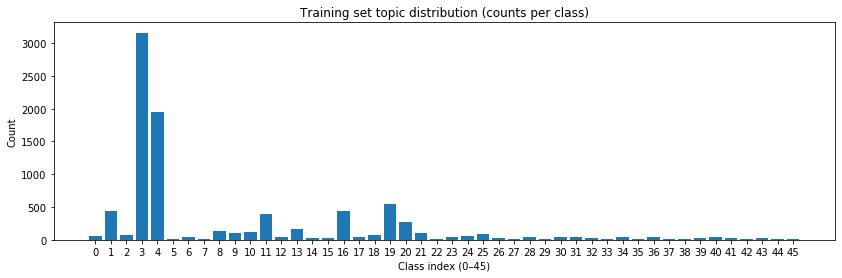

Min count in a class: 10
Max count in a class: 3159


In [4]:
# Bar chart of counts per class that is ordered by class index for readability
plt.figure(figsize=(14, 4))
plt.bar(np.arange(46), counts)
plt.title("Training set topic distribution (counts per class)")
plt.xlabel("Class index (0–45)")
plt.ylabel("Count")
plt.xticks(np.arange(46))
plt.show()

print("Min count in a class:", counts.min())
print("Max count in a class:", counts.max())

## b) Inspect one random newswire from the training set

In [5]:
# Build the decoding dictionary with the same approach as the example notebook
word_index = reuters.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

# Pick random newswire
sample_index = random.randrange(len(train_data))
sample_sequence = train_data[sample_index]

# Decode where indices are offset by 3 due to reserved tokens
decoded_text = " ".join([reverse_word_index.get(i - 3, "?") for i in sample_sequence])

print(f"Random training sample index: {sample_index}")
print("\nDecoded text:\n")
print(decoded_text)

Random training sample index: 857

Decoded text:

? an investment group led by audio video affiliates inc said it raised its tender offer to acquire cyclops corp to 92 50 dlrs a share from 80 dlrs a share the group cyacq acquisition corp also said it extended the offer until april three from march 20 the group said it added several conditions to its offer including receipt of all non public information about cyclops that was provided to lt dixons group plc in connection with ? competing tender offer for cyclops cyacq's sweetened offer totaling about 398 mln dlrs ? ? offer of 92 25 dlrs a share or about 388 mln dlrs on wednesday dixon said it had bought 54 pct of cyclops' 4 3 mln shares outstanding boosting its stake in the company to 56 pct earlier today however the securities and exchange ? ordered dixons to extended its tender offer until march 24 cyacq said it hopes cyclops shareholders will withdraw previously tendered shares from dixons' tender offer to take advantage of cyacq's h

In [6]:
# Show the first 200 entries of the vectorized 10,000-d representation
sample_vector = x_train[sample_index]  
print("First 200 entries of the 10,000-d input vector:")
print(sample_vector[:200])
print("\nNumber of 1s in the full 10,000-d vector:", int(sample_vector.sum()))

First 200 entries of the 10,000-d input vector:
[0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0.]

Number of 1s in the full 10,000-d vector: 140


## c) Inspect the label for the same newswire

In [7]:
try:
    label_names = list(reuters.get_label_names())
except Exception:
    label_names = [
        "cocoa", "grain", "veg-oil", "earn", "acq", "wheat", "copper", "housing",
        "money-supply", "coffee", "sugar", "trade", "reserves", "ship", "cotton",
        "carcass", "crude", "nat-gas", "cpi", "money-fx", "interest", "gnp",
        "meal-feed", "alum", "oilseed", "gold", "tin", "strategic-metal",
        "livestock", "retail", "ipi", "iron-steel", "rubber", "heat", "jobs",
        "lei", "bop", "zinc", "orange", "pet-chem", "dlr", "gas", "silver",
        "wpi", "hog", "lead"
    ]

true_label_index = int(train_labels_arr[sample_index])
true_label_name = label_names[true_label_index]

print("Topic label (class index):", true_label_index)
print("Topic name:", true_label_name)

print("\nOne-hot encoded label vector (length 46):")
print(one_hot_train_labels[sample_index])
print("\nVector sums to:", int(one_hot_train_labels[sample_index].sum()))


Topic label (class index): 4
Topic name: acq

One-hot encoded label vector (length 46):
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Vector sums to: 1


## d) Modify the network to add Dropout layers and train until validation accuracy converges

In [8]:
def build_dropout_model(dropout_rate=0.2):
    model = models.Sequential()
    model.add(layers.Dense(64, activation="relu", input_shape=(10000,)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(46, activation="softmax"))

    model.compile(
        optimizer="rmsprop",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

dropout_rate = 0.2
dropout_model = build_dropout_model(dropout_rate=dropout_rate)

early_stop = EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    patience=3,
    min_delta=0.001,
    restore_best_weights=True,
)

history_dropout = dropout_model.fit(
    partial_x_train,
    partial_y_train,
    epochs=50,              
    batch_size=512,
    validation_data=(x_val, y_val),
    callbacks=[early_stop],
    verbose=1,
)

Epoch 1/50
16/16 [==============================] - 2s 36ms/step - loss: 2.8361 - accuracy: 0.4168 - val_loss: 1.9285 - val_accuracy: 0.5920
Epoch 2/50
16/16 [==============================] - 0s 18ms/step - loss: 1.7572 - accuracy: 0.6150 - val_loss: 1.4571 - val_accuracy: 0.6710
Epoch 3/50
16/16 [==============================] - 0s 22ms/step - loss: 1.3875 - accuracy: 0.6911 - val_loss: 1.2588 - val_accuracy: 0.7020
Epoch 4/50
16/16 [==============================] - 0s 20ms/step - loss: 1.1963 - accuracy: 0.7263 - val_loss: 1.1493 - val_accuracy: 0.7350
Epoch 5/50
16/16 [==============================] - 0s 21ms/step - loss: 1.0292 - accuracy: 0.7643 - val_loss: 1.0699 - val_accuracy: 0.7520
Epoch 6/50
16/16 [==============================] - 0s 23ms/step - loss: 0.9075 - accuracy: 0.7908 - val_loss: 1.0168 - val_accuracy: 0.7640
Epoch 7/50
16/16 [==============================] - 0s 19ms/step - loss: 0.8103 - accuracy: 0.8165 - val_loss: 0.9694 - val_accuracy: 0.7810
Epoch 8/50
16

## e) Plot training accuracy and validation accuracy vs. epochs with dropout model

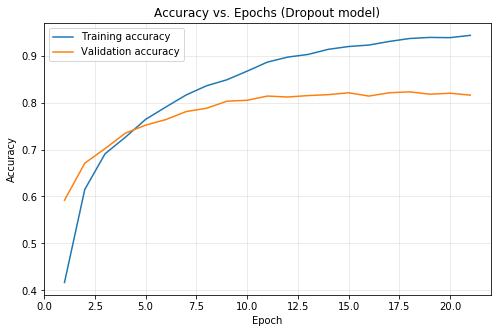

Best validation accuracy: 0.8230000138282776
Epoch at best validation accuracy: 18


In [9]:
hist = history_dropout.history

train_acc = hist.get("accuracy", hist.get("acc"))
val_acc = hist.get("val_accuracy", hist.get("val_acc"))

epochs = np.arange(1, len(train_acc) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc, label="Training accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.title("Accuracy vs. Epochs (Dropout model)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Best validation accuracy:", float(np.max(val_acc)))
print("Epoch at best validation accuracy:", int(np.argmax(val_acc) + 1))

## f) Evaluate the trained Dropout model on the test set

In [10]:
test_loss, test_acc = dropout_model.evaluate(x_test, one_hot_test_labels, verbose=0)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Test loss: 0.9955697059631348
Test accuracy: 0.800979495048523


## g) Show 10 random test examples with true vs. predicted topics

In [11]:
pred_probs = dropout_model.predict(x_test, verbose=0)
pred_classes = np.argmax(pred_probs, axis=1)

test_labels_arr = np.array(test_labels)

k = 10
indices = np.random.choice(len(x_test), size=k, replace=False)

rows = []
correct = 0
for idx in indices:
    true_idx = int(test_labels_arr[idx])
    pred_idx = int(pred_classes[idx])

    true_name = label_names[true_idx]
    pred_name = label_names[pred_idx]

    is_correct = (true_idx == pred_idx)
    correct += int(is_correct)

    rows.append({
        "test_index": int(idx),
        "true_class": true_idx,
        "true_topic": true_name,
        "pred_class": pred_idx,
        "pred_topic": pred_name,
        "correct?": is_correct,
    })

result_df = pd.DataFrame(rows)
result_df

,test_index,true_class,true_topic,pred_class,pred_topic,correct?
0,1998,4,acq,4,acq,True
1,1360,1,grain,1,grain,True
2,1178,1,grain,1,grain,True
3,1299,18,cpi,18,cpi,True
4,33,1,grain,3,earn,False
5,779,11,trade,11,trade,True
6,2149,0,cocoa,0,cocoa,True
7,2128,4,acq,4,acq,True
8,1542,4,acq,4,acq,True
9,352,3,earn,3,earn,True


In [12]:
print(f"Correct predictions among these {k} examples: {correct}/{k}")

Correct predictions among these 10 examples: 9/10
